# Ville de Seattle
## Prédire les émissions de CO2 et la consommation totale d’énergie

Ce notebook cherche à utiliser plusieurs méthodes différentes pour prédire le plus précisément possible la consommation totale d'énergie des batiments de la ville de Seattle, en utilisant les diverses caractéristiques de ces derniers (surface totale, nombre d'étages, fonction du batiment...)

Dans un second temps, je montrerais que le 'ENERGYSTAR Score' (https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/how-1-100) qui est couramment utilisé aux Etats-Unis, lorsqu'il est utilisé seul est un très mauvais prédicteur de consommation energétique, et j'expliquerais pourquoi.

Enfin je montrerais que le fait d'inclure le 'ENERGYSTAR Score' peut très légèrement amméliorer la prédiction, mais qu'il s'agit de Data Leakage.

### 1. Importation des données

In [1]:
import pandas as pd

In [2]:
Data2015 = pd.read_csv('/home/edward/Documents/2015-building-energy-benchmarking.csv', sep=',')
Data2016 = pd.read_csv('/home/edward/Documents/2016-building-energy-benchmarking.csv', sep=',')

# Rename 'GHGEmissions(MetricTonsCO2e)' from Data2015, as name of identical variable in Data2016

Data2015['TotalGHGEmissions'] = Data2015['GHGEmissions(MetricTonsCO2e)']

In [3]:
# Concatenating 2015 and 2016 Databases

Common_Columns = []    
    
for i in range(len(Data2016.columns)):
    if Data2016.columns[i] in Data2015.columns:
        Common_Columns.append(Data2016.columns[i])

Data2015_Common = Data2015[Common_Columns]
Data2016_Common = Data2016[Common_Columns]

Data = pd.concat([Data2015_Common, Data2016_Common])

Data.reset_index(drop=True, inplace=True)

DataObservationsRaw = len(Data)

In [4]:
# Clean all 'PrimaryPropertyType' (remove spaces and \n)

for i in range(len(Data['PrimaryPropertyType'])):
    Data['PrimaryPropertyType'].iloc[i] = Data['PrimaryPropertyType'].iloc[i].replace(" ", "")
    Data['PrimaryPropertyType'].iloc[i] = Data['PrimaryPropertyType'].iloc[i].replace("\n", "")

    
Data['PrimaryPropertyType'][Data['PrimaryPropertyType'] == 'College/University'] = 'University'
Data['PrimaryPropertyType'][Data['PrimaryPropertyType'] == 'SPS-DistrictK-12'] = 'K-12School'

/home/edward/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-4-d002a0b5b2dd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['PrimaryPropertyType'][Data['PrimaryPropertyType'] == 'College/University'] = 'University'
<ipython-input-4-d002a0b5b2dd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['PrimaryP

In [5]:
# Drop NAN and INFs for most important variables

import numpy as np

Data['Ones'] = 1

Data = Data.dropna(subset=['YearBuilt'])
Data = Data.drop(Data[Data['YearBuilt'] == np.inf].index)
                   
Data = Data.dropna(subset=['NumberofBuildings'])
Data = Data.drop(Data[Data['NumberofBuildings'] == np.inf].index)            
                   
Data = Data.dropna(subset=['NumberofFloors'])
Data = Data.drop(Data[Data['NumberofFloors'] == np.inf].index)

Data = Data.dropna(subset=['Electricity(kWh)'])
Data = Data.drop(Data[Data['Electricity(kWh)'] == np.inf].index)
                   
Data = Data.dropna(subset=['PropertyGFATotal'])
Data = Data.drop(Data[Data['PropertyGFATotal'] == np.inf].index)
                   
Data = Data.dropna(subset=['SiteEnergyUseWN(kBtu)'])
Data = Data.drop(Data[Data['SiteEnergyUseWN(kBtu)'] == np.inf].index)
                     
Data = Data.dropna(subset=['SiteEnergyUse(kBtu)'])
Data = Data.drop(Data[Data['SiteEnergyUse(kBtu)'] == np.inf].index) 

In [6]:
# Remove outliers by dropping observations where the predicted Electricity and Gas consumption is extremely different from real Electricity and Gas consumption

    # 1. Create dummy variables for all building types
    
        # 1.1. Store all property-type names in list

Property_Type = []

for i in range(len(Data['PrimaryPropertyType'])):
    if Data['PrimaryPropertyType'].iloc[i] not in Property_Type:
        Property_Type.append(Data['PrimaryPropertyType'].iloc[i])
        
    
        # 1.2. Create dummy variables for each proporty-type
    
for i in range(len(Property_Type)):
    Data[Property_Type[i]] = 0
    Data[Property_Type[i]][Data['PrimaryPropertyType'] == Property_Type[i]] = 1
    Data[Property_Type[i]+'GPA'] = 0
    Data[Property_Type[i]+'GPA'][Data['PrimaryPropertyType'] == Property_Type[i]] = Data['PropertyGFATotal'][Data['PrimaryPropertyType'] == Property_Type[i]]

        # 1.3. Create "interaction variables" between property-type and building surface 
        # (This will enable the linear regression to take into account the fact different building types have different relations between energy consumption and building surface)    
        # (It is done by doing Dummy X 'GPA')
        
Property_Type_GPA = []

for i in range(len(Property_Type)):
    Property_Type_GPA.append(Property_Type[i] + 'GPA')

    

<ipython-input-6-0244ea0a1395>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data[Property_Type[i]][Data['PrimaryPropertyType'] == Property_Type[i]] = 1
<ipython-input-6-0244ea0a1395>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data[Property_Type[i]+'GPA'][Data['PrimaryPropertyType'] == Property_Type[i]] = Data['PropertyGFATotal'][Data['PrimaryPropertyType'] == Property_Type[i]]
<ipython-input-6-0244ea0a1395>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

### 2. Quelques Graphiques sur les variables principales

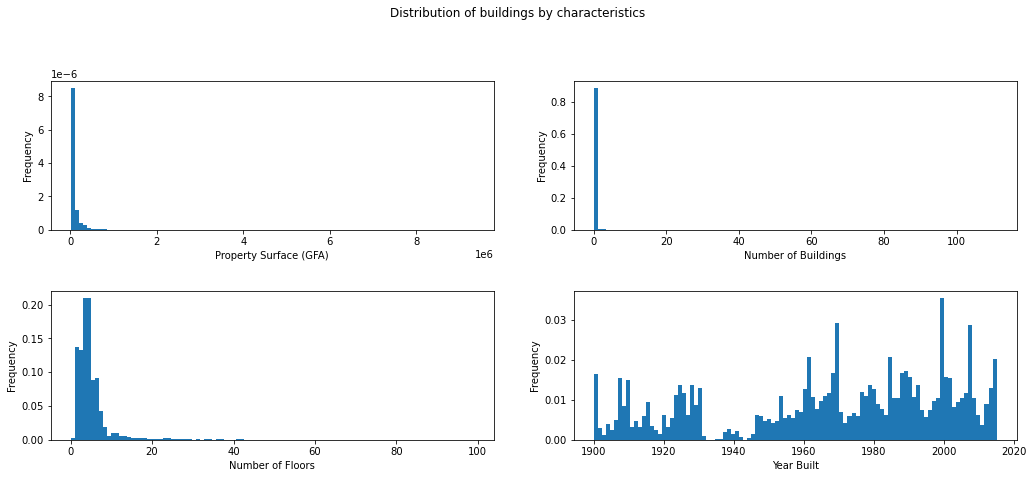

In [7]:
# Histogram of main Standardized Variables

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type + Property_Type_GPA].iloc[0:10000000]


import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('Distribution of buildings by characteristics')

axs[0, 0].hist(Data['PropertyGFATotal'], bins=100, density=True)
axs[0, 0].set(xlabel='Property Surface (GFA)', ylabel='Frequency')
 
axs[0, 1].hist(Data['NumberofBuildings'], bins=100, density=True)
axs[0, 1].set(xlabel='Number of Buildings', ylabel='Frequency')

axs[1, 0].hist(Data['NumberofFloors'], bins=100, density=True)
axs[1, 0].set(xlabel='Number of Floors', ylabel='Frequency')

axs[1, 1].hist(Data['YearBuilt'], bins=100, density=True)
axs[1, 1].set(xlabel='Year Built', ylabel='Frequency')

fig.tight_layout(pad=3.0)

In [8]:
# Calculate Electricity consumption and Energy consumption per GFA (this will be usefull later on)
        
Data['ElectricityPerGFA'] = Data['Electricity(kWh)'] / Data['PropertyGFATotal']        
Data['EnergyPerGFA'] = Data['SiteEnergyUse(kBtu)'] / Data['PropertyGFATotal']

# Standardize all input variables

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal'] + Property_Type + Property_Type_GPA] = min_max_scaler.fit_transform(Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal'] + Property_Type + Property_Type_GPA])

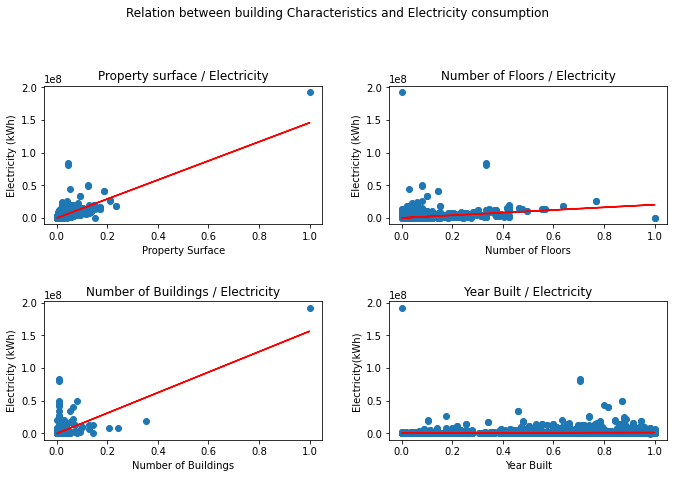

In [9]:
# Relation between building characteristics and Electricity consumption

fig, axs = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)

fig.suptitle('Relation between building Characteristics and Electricity consumption')

axs[0, 0].scatter(Data['PropertyGFATotal'], Data['Electricity(kWh)'])
axs[0, 0].set_title('Property surface / Electricity')

X = Data['PropertyGFATotal'].iloc[0:100000]
y = Data['Electricity(kWh)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 0].plot(Data['PropertyGFATotal'], Data['PropertyGFATotal']*m+b, color='red')
axs[0, 0].set(xlabel='Property Surface', ylabel='Electricity (kWh)')

axs[0, 1].scatter(Data['NumberofFloors'], Data['Electricity(kWh)'])
axs[0, 1].set_title('Number of Floors / Electricity')

X = Data['NumberofFloors'].iloc[0:100000]
y = Data['Electricity(kWh)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 1].plot(Data['NumberofFloors'], Data['NumberofFloors']*m+b, color='red')
axs[0, 1].set(xlabel='Number of Floors', ylabel='Electricity (kWh)')

axs[1, 0].scatter(Data['NumberofBuildings'], Data['Electricity(kWh)'])
axs[1, 0].set_title('Number of Buildings / Electricity')

X = Data['NumberofBuildings'].iloc[0:100000]
y = Data['Electricity(kWh)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 0].plot(Data['NumberofBuildings'], Data['NumberofBuildings']*m+b, color='red')
axs[1, 0].set(xlabel='Number of Buildings', ylabel='Electricity (kWh)')


axs[1, 1].scatter(Data['YearBuilt'], Data['Electricity(kWh)'])
axs[1, 1].set_title('Year Built / Electricity')

X = Data['YearBuilt'].iloc[0:100000]
y = Data['Electricity(kWh)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 1].plot(Data['YearBuilt'], Data['YearBuilt']*m+b, color='red')
axs[1, 1].set(xlabel='Year Built', ylabel='Electricity(kWh)')


fig.tight_layout(pad=3.0)

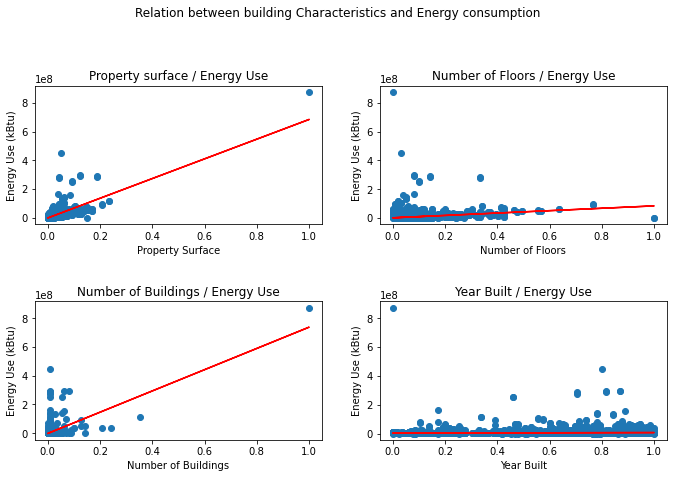

In [10]:
# Relation between building characteristics and Energy consumption

fig, axs = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)

fig.suptitle('Relation between building Characteristics and Energy consumption')

axs[0, 0].scatter(Data['PropertyGFATotal'], Data['SiteEnergyUse(kBtu)'])
axs[0, 0].set_title('Property surface / Energy Use')

X = Data['PropertyGFATotal'].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 0].plot(Data['PropertyGFATotal'], Data['PropertyGFATotal']*m+b, color='red')
axs[0, 0].set(xlabel='Property Surface', ylabel='Energy Use (kBtu)')

axs[0, 1].scatter(Data['NumberofFloors'], Data['SiteEnergyUse(kBtu)'])
axs[0, 1].set_title('Number of Floors / Energy Use')

X = Data['NumberofFloors'].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 1].plot(Data['NumberofFloors'], Data['NumberofFloors']*m+b, color='red')
axs[0, 1].set(xlabel='Number of Floors', ylabel='Energy Use (kBtu)')

axs[1, 0].scatter(Data['NumberofBuildings'], Data['SiteEnergyUse(kBtu)'])
axs[1, 0].set_title('Number of Buildings / Energy Use')

X = Data['NumberofBuildings'].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 0].plot(Data['NumberofBuildings'], Data['NumberofBuildings']*m+b, color='red')
axs[1, 0].set(xlabel='Number of Buildings', ylabel='Energy Use (kBtu)')


axs[1, 1].scatter(Data['YearBuilt'], Data['SiteEnergyUse(kBtu)'])
axs[1, 1].set_title('Year Built / Energy Use')

X = Data['YearBuilt'].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 1].plot(Data['YearBuilt'], Data['YearBuilt']*m+b, color='red')
axs[1, 1].set(xlabel='Year Built', ylabel='Energy Use (kBtu)')


fig.tight_layout(pad=3.0)

Ensuite, j'étudie si la relation entre la surface d'un batiment et la consommation d'électricité et d'énergie sont eux-même une fonction du type d'activité exercé dans le batiment.

Text(0.5, 1.0, 'Box Plot of Electricity/GFA for each Building Type')

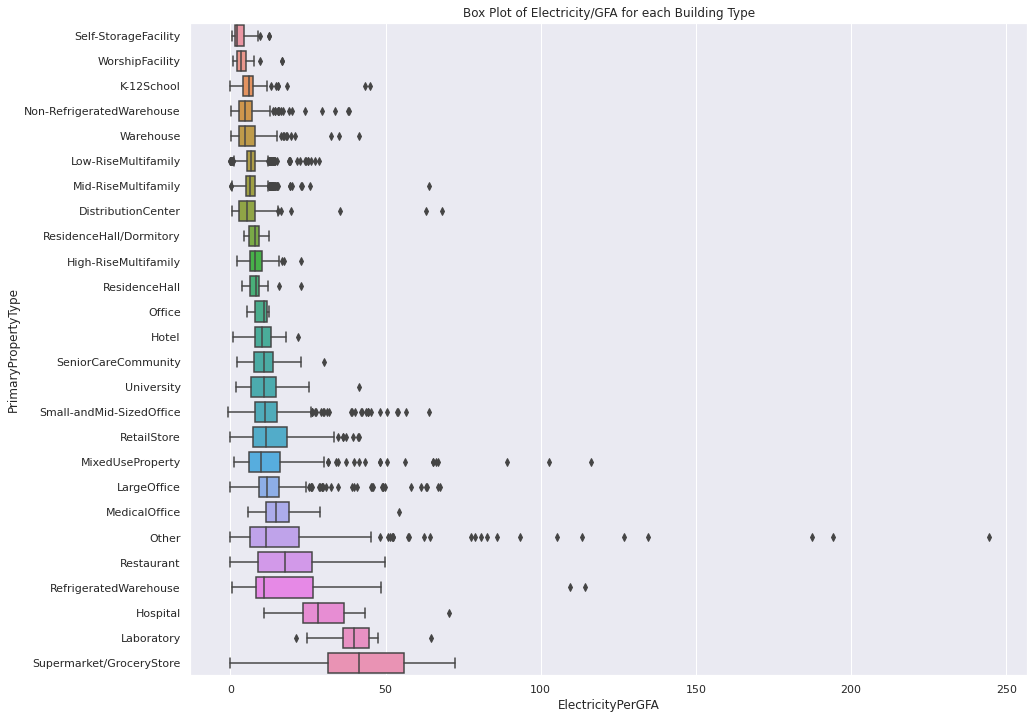

In [11]:
# Re-Order list of Property_Type by mean Electricity/GFA

    # Store mean Electricity/GFA in list
    
Mean_ElectricityPerGFA = []

for i in range(len(Property_Type)):
    Mean_ElectricityPerGFA.append(Data['ElectricityPerGFA'][Data['PrimaryPropertyType'] == Property_Type[i]].mean())

    # Re-Order list of Property_Type using Mean_ElectricityPerGFA list
    
Property_Type_ElecOrder = [Property_Type for _,Property_Type in sorted(zip(Mean_ElectricityPerGFA,Property_Type))]
Mean_ElectricityPerGFA = sorted(Mean_ElectricityPerGFA)



# Distribution of 'ElectricityPerGFA' for each Building Type

import seaborn as sns

sns.set(rc={'figure.figsize':(15,12)})

sns.boxplot(x='ElectricityPerGFA', y='PrimaryPropertyType', data=Data, order=Property_Type_ElecOrder).set_title('Box Plot of Electricity/GFA for each Building Type')

Text(0.5, 1.0, 'Box Plot of Gas/GFA for each Building Type')

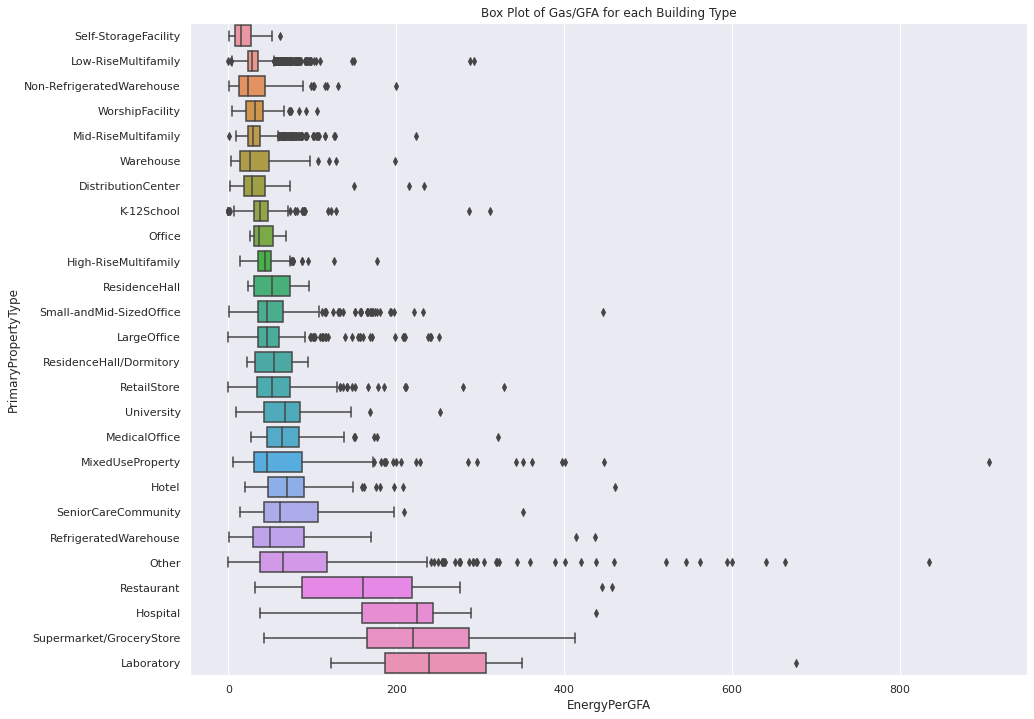

In [12]:
# Re-Order list of Property_Type by mean Energy/GFA

    # Store mean Energy/GFA in list

Mean_EnergyPerGFA = []

for i in range(len(Property_Type)):
    Mean_EnergyPerGFA.append(Data['EnergyPerGFA'][Data['PrimaryPropertyType'] == Property_Type[i]].mean())

    # Re-Order list of Property_Type using Mean_GasPerGFA list

Property_Type_EnergyOrder = [Property_Type for _,Property_Type in sorted(zip(Mean_EnergyPerGFA,Property_Type))]
Mean_EnergyPerGFA = sorted(Mean_EnergyPerGFA)



# Distribution of 'GasPerGFA' for each Building Type

sns.set(rc={'figure.figsize':(15,12)})

sns.boxplot(x='EnergyPerGFA', y='PrimaryPropertyType', data=Data, order=Property_Type_EnergyOrder).set_title('Box Plot of Gas/GFA for each Building Type')

Ces deux graphiques confirment que certains types de batiments ont une plus grande intensité de consommation énergétique que d'autres.
On voit par exemple que les Supermarchés, les laboratoires et les restaurants consomment une bien plus grande quantité d'énergie pour une surface équivalente, que des dépots (self-storage facilities) ou des hangars (Warehouse).

Pour cette raison, il est essentiel d'ajouter des variables d'intéraction dans les régressions linéaires (dummy type de batiment X surface).

### 3. Prédiction de la consommation d'Energie

#### 3.0. Regression Linéaire simple

L'utilisation de la régression linéaire pour prédire la consommation d'énergie est surtout pour montrer ce que l'on peut obtenir comme résultats, en utilisant la méthode la plus simple-possible.

In [13]:
from sklearn.utils import shuffle

Data = shuffle(Data)

DataOriginal = Data


# 2. Make Linear Regression to Predict Electricity consumption, and drop observations where prediction are extremely different from real consumption
    
        # 2.1. Make Linear Regression to Predict Electricity consumption
        
import numpy as np
from sklearn.linear_model import LinearRegression

Data['Ones'] = 1

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type + Property_Type_GPA].iloc[0:10000000]
y = Data['Electricity(kWh)'].iloc[0:10000000]

reg = LinearRegression().fit(X, y)

Predicted_y = reg.predict(X)

Data['Predicted_y'] = reg.predict(X)
Data['Difference'] = abs(Data['Predicted_y'] - Data['Electricity(kWh)'])

        # 2.2. Drop observations where predicted value is more different than 5 times the top 10% highest prediction errors

Error90thQuantile = np.quantile(Data['Difference'], 0.90)
Data = Data[Data['Difference'] <= 5*Error90thQuantile]
Data.drop(['Difference', 'Predicted_y'], inplace=True, axis=1)


    # 3. Make Linear Regression to Predict Gas consumption, and drop observations where prediction are extremely different from real consumption
    
        # 3.1. Make Linear Regression to Predict Gas consumption

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type + Property_Type_GPA].iloc[0:10000000]
y = Data['NaturalGas(therms)'].iloc[0:10000000]

reg = LinearRegression().fit(X, y)

Predicted_y = reg.predict(X)

Data['Predicted_y'] = reg.predict(X)
Data['Difference'] = abs(Data['Predicted_y'] - Data['NaturalGas(therms)'])

        # 3.2. Drop observations where predicted value is more different than 5 times the top 10% highest prediction errors

Error90thQuantile = np.quantile(Data['Difference'], 0.90)
Data = Data[Data['Difference'] <= 5*Error90thQuantile]
Data.drop(['Difference', 'Predicted_y'], inplace=True, axis=1)

DataObservationsClean = len(Data)

print('Original Number of Obersavtions : ', DataObservationsRaw)
print('Final Number of Obersavtions : ', DataObservationsClean)
Percentage = (1 - DataObservationsClean / DataObservationsRaw)*100
print('Percentage Dropped : ', round(Percentage, 3), '%')

print(' ')
print(len(Data))
print(len(DataOriginal))

Original Number of Obersavtions :  6716
Final Number of Obersavtions :  6580
Percentage Dropped :  2.025 %
 
6580
6688


/home/edward/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-13-cfa881d99ed7>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Predicted_y'] = reg.predict(X)
<ipython-input-13-cfa881d99ed7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.linear_model import LinearRegression
import time
import datetime


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


StartEnergy = time.perf_counter()

reg = LinearRegression().fit(X_train, y_train)

Predicted_y = reg.predict(X_train)
LinSiteEnergyTraining_R2 =  reg.score(X_train, y_train)
LinSiteEnergyTraining_R2 = round(LinSiteEnergyTraining_R2, 3)

AdLinSiteEnergyTraining_R2 = 1 - ((1-reg.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdLinSiteEnergyTraining_R2 = round(AdLinSiteEnergyTraining_R2, 3)

LinSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
LinSiteEnergyTraining_MSE = round(LinSiteEnergyTraining_MSE)

LinSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
LinSiteEnergyTraining_MAE = round(LinSiteEnergyTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Predicted_y = reg.predict(X_test)
LinSiteEnergyTest_R2 = reg.score(X_test, y_test)
LinSiteEnergyTest_R2 = round(LinSiteEnergyTest_R2, 3)

AdLinSiteEnergyTest_R2 = 1 - ((1-reg.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdLinSiteEnergyTest_R2 = round(AdLinSiteEnergyTest_R2, 3)

LinSiteEnergyTest_MSE = mean_squared_error(Predicted_y , y_test)
LinSiteEnergyTest_MSE = round(LinSiteEnergyTest_MSE)

LinSiteEnergyTest_MAE = mean_absolute_error(Predicted_y , y_test)
LinSiteEnergyTest_MAE = round(LinSiteEnergyTest_MAE)

EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0
    
TimeEnergy = round(TimeEnergy, 0)
LinTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

reg = LinearRegression().fit(X_train, y_train)

Predicted_y = reg.predict(X_train)
LinSiteEnergyWNTraining_R2 =  reg.score(X_train, y_train)
LinSiteEnergyWNTraining_R2 = round(LinSiteEnergyWNTraining_R2, 3)

AdLinSiteEnergyWNTraining_R2 = 1 - ((1-reg.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdLinSiteEnergyWNTraining_R2 = round(AdLinSiteEnergyWNTraining_R2, 3)

LinSiteEnergyWNTraining_MSE = mean_squared_error(Predicted_y, y_train)
LinSiteEnergyWNTraining_MSE = round(LinSiteEnergyWNTraining_MSE)

LinSiteEnergyWNTraining_MAE = mean_absolute_error(Predicted_y, y_train)
LinSiteEnergyWNTraining_MAE = round(LinSiteEnergyWNTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = reg.predict(X_test)
LinSiteEnergyWNTest_R2 = reg.score(X_test, y_test)
LinSiteEnergyWNTest_R2 = round(LinSiteEnergyWNTest_R2, 3)

AdLinSiteEnergyWNTest_R2 = 1 - ((1-reg.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdLinSiteEnergyWNTest_R2 = round(AdLinSiteEnergyWNTest_R2, 3)

LinSiteEnergyWNTest_MSE = mean_squared_error(Predicted_y , y_test)
LinSiteEnergyWNTest_MSE = round(LinSiteEnergyWNTest_MSE)

LinSiteEnergyWNTest_MAE = mean_absolute_error(Predicted_y , y_test)
LinSiteEnergyWNTest_MAE = round(LinSiteEnergyWNTest_MAE)

EndEnergyWN = time.perf_counter()

TimeEnergyWN = EndEnergyWN - StartEnergyWN

if TimeEnergyWN < 0:
    TimeEnergyWN = 0
    
TimeEnergyWN = round(TimeEnergyWN, 0)
LinTimeEnergyWN = str(datetime.timedelta(seconds=TimeEnergyWN))



X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


StartEnergy = time.perf_counter()

reg = LinearRegression().fit(X_train, y_train)

Predicted_y = reg.predict(X_train)
LinCO2Training_R2 =  reg.score(X_train, y_train)
LinCO2Training_R2 = round(LinCO2Training_R2, 3)

AdLinCO2Training_R2 = 1 - ((1-reg.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdLinCO2Training_R2 = round(AdLinCO2Training_R2, 3)

LinCO2Training_MSE =  mean_squared_error(Predicted_y, y_train)
LinCO2Training_MSE = round(LinCO2Training_MSE)

LinCO2Training_MAE =  mean_absolute_error(Predicted_y, y_train)
LinCO2Training_MAE = round(LinCO2Training_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Predicted_y = reg.predict(X_test)
LinCO2Test_R2 = reg.score(X_test, y_test)
LinCO2Test_R2 = round(LinCO2Test_R2, 3)

AdLinCO2Test_R2 = 1 - ((1-reg.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdLinCO2Test_R2 = round(AdLinCO2Test_R2, 3)

LinCO2Test_MSE = mean_squared_error(Predicted_y , y_test)
LinCO2Test_MSE = round(LinCO2Test_MSE)

LinCO2Test_MAE = mean_absolute_error(Predicted_y , y_test)
LinCO2Test_MAE = round(LinCO2Test_MAE)

EndEnergy = time.perf_counter()

TimeCO2 = EndEnergy - StartEnergy

if TimeCO2 < 0:
    TimeCO2 = 0
    
TimeCO2 = round(TimeCO2, 0)
LinTimeCO2 = str(datetime.timedelta(seconds=TimeCO2))

space = 27
space2 = 17

print('Linear Regressions:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{LinSiteEnergyTraining_R2 : ^{space2}}{AdLinSiteEnergyTraining_R2 : ^{space2}}{LinSiteEnergyTraining_MSE : ^{space2}}{LinSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{LinSiteEnergyTest_R2 : ^{space2}}{AdLinSiteEnergyTest_R2 : ^{space2}}{LinSiteEnergyTest_MSE : ^{space2}}{LinSiteEnergyTest_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")

print(' ')

print(f"{'Site Energy WN Training : ' : <{space}}{LinSiteEnergyWNTraining_R2 : ^{space2}}{AdLinSiteEnergyWNTraining_R2 : ^{space2}}{LinSiteEnergyWNTraining_MSE : ^{space2}}{LinSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'Site Energy WN Test : ' : <{space}}{LinSiteEnergyWNTest_R2 : ^{space2}}{AdLinSiteEnergyWNTest_R2 : ^{space2}}{LinSiteEnergyWNTest_MSE : ^{space2}}{LinSiteEnergyWNTest_MAE : ^{space2}}{LinTimeEnergyWN : ^{space2}}")


print(' ')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'CO2 Training : ' : <{space}}{LinCO2Training_R2 : ^{space2}}{AdLinCO2Training_R2 : ^{space2}}{LinCO2Training_MSE : ^{space2}}{LinCO2Training_MAE : ^{space2}}")
print(f"{'CO2 Test : ' : <{space}}{LinCO2Test_R2 : ^{space2}}{AdLinCO2Test_R2 : ^{space2}}{LinCO2Test_MSE : ^{space2}}{LinCO2Test_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")

Linear Regressions:
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
Site Energy Training :           0.882            0.88         8344451785965       1428852     
Site Energy Test :               0.606            0.598       62531297942341       2120524          0:00:00     
 
Site Energy WN Training :        0.85             0.848       10711487075682       1564062     
Site Energy WN Test :            0.595            0.586       67124137496466       2273833          0:00:00     
 
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
CO2 Training :                   0.79             0.787            11270             50        
CO2 Test :                       0.618            0.61             39892             67             0:00:00     


#### 3.1. Régression KNN

J'utilise un Grid Search pour trouver le nombre de voisins optimaux dans une Regression KNN

In [15]:
# Use GridSearch to optimize number of neighbours in KNN

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergy = time.perf_counter()

param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

score = 'r2'

KNN = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,    
    cv=5,          
    scoring=score   
)

KNN.fit(X_train, y_train)

KNNSiteEnergy_BestParameters = KNN.best_params_

Best_KNN = neighbors.KNeighborsRegressor(n_neighbors=KNNSiteEnergy_BestParameters['n_neighbors'])

Best_KNN.fit(X_train, y_train)

Predicted_y = Best_KNN.predict(X_train)
KNNSiteEnergyTraining_R2 =  Best_KNN.score(X_train, y_train)
KNNSiteEnergyTraining_R2 = round(KNNSiteEnergyTraining_R2, 3)

AdKNNSiteEnergyTraining_R2 = 1 - ((1-Best_KNN.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdKNNSiteEnergyTraining_R2 = round(AdKNNSiteEnergyTraining_R2, 3)

KNNSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
KNNSiteEnergyTraining_MSE = round(KNNSiteEnergyTraining_MSE)

KNNSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
KNNSiteEnergyTraining_MAE = round(KNNSiteEnergyTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = Best_KNN.predict(X_test)
KNNSiteEnergyTest_R2 =  Best_KNN.score(X_test, y_test)
KNNSiteEnergyTest_R2 = round(KNNSiteEnergyTest_R2, 3)

AdKNNSiteEnergyTest_R2 = 1 - ((1-Best_KNN.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdKNNSiteEnergyTest_R2 = round(AdKNNSiteEnergyTest_R2, 3)

KNNSiteEnergyTest_MSE =  mean_squared_error(Predicted_y, y_test)
KNNSiteEnergyTest_MSE = round(KNNSiteEnergyTest_MSE)

KNNSiteEnergyTest_MAE =  mean_absolute_error(Predicted_y, y_test)
KNNSiteEnergyTest_MAE = round(KNNSiteEnergyTest_MAE)



EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0

TimeEnergy = round(TimeEnergy, 0)
KNNTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

score = 'r2'

KNN = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,    
    cv=5,          
    scoring=score   
)

KNN.fit(X_train, y_train)

KNNSiteEnergyWN_BestParameters = KNN.best_params_

Best_KNN = neighbors.KNeighborsRegressor(n_neighbors=KNNSiteEnergyWN_BestParameters['n_neighbors'])

Best_KNN.fit(X_train, y_train)

Predicted_y = Best_KNN.predict(X_train)
KNNSiteEnergyWNTraining_R2 =  Best_KNN.score(X_train, y_train)
KNNSiteEnergyWNTraining_R2 = round(KNNSiteEnergyWNTraining_R2, 3)

AdKNNSiteEnergyWNTraining_R2 = 1 - ((1-Best_KNN.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdKNNSiteEnergyWNTraining_R2 = round(AdKNNSiteEnergyWNTraining_R2, 3)

KNNSiteEnergyWNTraining_MSE =  mean_squared_error(Predicted_y, y_train)
KNNSiteEnergyWNTraining_MSE = round(KNNSiteEnergyWNTraining_MSE)

KNNSiteEnergyWNTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
KNNSiteEnergyWNTraining_MAE = round(KNNSiteEnergyWNTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = Best_KNN.predict(X_test)
KNNSiteEnergyWNTest_R2 =  Best_KNN.score(X_test, y_test)
KNNSiteEnergyWNTest_R2 = round(KNNSiteEnergyWNTest_R2, 3)

AdKNNSiteEnergyWNTest_R2 = 1 - ((1-Best_KNN.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdKNNSiteEnergyWNTest_R2 = round(AdKNNSiteEnergyWNTest_R2, 3)

KNNSiteEnergyWNTest_MSE =  mean_squared_error(Predicted_y, y_test)
KNNSiteEnergyWNTest_MSE = round(KNNSiteEnergyWNTest_MSE)

KNNSiteEnergyWNTest_MAE =  mean_absolute_error(Predicted_y, y_test)
KNNSiteEnergyWNTest_MAE = round(KNNSiteEnergyWNTest_MAE)


EndEnergyWN = time.perf_counter()

TimeEnergyWN = EndEnergyWN - StartEnergyWN 


if TimeEnergyWN < 0:
    TimeEnergyWN = 0

TimeEnergyWN = round(TimeEnergyWN, 0)
KNNTimeEnergyWN = str(datetime.timedelta(seconds=TimeEnergyWN))


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

score = 'r2'

KNN = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(),
    param_grid,    
    cv=5,          
    scoring=score   
)



KNN.fit(X_train, y_train)

KNNCO2_BestParameters = KNN.best_params_

Best_KNN = neighbors.KNeighborsRegressor(n_neighbors=KNNCO2_BestParameters['n_neighbors'])

Best_KNN.fit(X_train, y_train)

Predicted_y = Best_KNN.predict(X_train)
KNNCO2Training_R2 =  Best_KNN.score(X_train, y_train)
KNNCO2Training_R2 = round(KNNCO2Training_R2, 3)

AdKNNCO2Training_R2 = 1 - ((1-Best_KNN.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdKNNCO2Training_R2 = round(AdKNNCO2Training_R2, 3)

KNNCO2Training_MSE =  mean_squared_error(Predicted_y, y_train)
KNNCO2Training_MSE = round(KNNCO2Training_MSE)

KNNCO2Training_MAE =  mean_absolute_error(Predicted_y, y_train)
KNNCO2Training_MAE = round(KNNCO2Training_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = Best_KNN.predict(X_test)
KNNCO2Test_R2 =  Best_KNN.score(X_test, y_test)
KNNCO2Test_R2 = round(KNNCO2Test_R2, 3)

AdKNNCO2Test_R2 = 1 - ((1-Best_KNN.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdKNNCO2Test_R2 = round(AdKNNCO2Test_R2, 3)

KNNCO2Test_MSE =  mean_squared_error(Predicted_y, y_test)
KNNCO2Test_MSE = round(KNNCO2Test_MSE)

KNNCO2Test_MAE =  mean_absolute_error(Predicted_y, y_test)
KNNCO2Test_MAE = round(KNNCO2Test_MAE)


EndEnergy = time.perf_counter()


TimeCO2 = EndEnergy - StartEnergy 


if TimeCO2 < 0:
    TimeCO2 = 0

TimeCO2 = round(TimeCO2, 0)
KNNTimeCO2 = str(datetime.timedelta(seconds=TimeCO2))

space = 27
space2 = 17

print('KNN Regressions:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}{'Best_Parameters : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{KNNSiteEnergyTraining_R2 : ^{space2}}{AdKNNSiteEnergyTraining_R2 : ^{space2}}{KNNSiteEnergyTraining_MSE : ^{space2}}{KNNSiteEnergyTraining_MAE : ^{space2}}{' ' : ^{space2}}{list(KNNSiteEnergyWN_BestParameters)[0] : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{KNNSiteEnergyTest_R2 : ^{space2}}{AdKNNSiteEnergyTest_R2 : ^{space2}}{KNNSiteEnergyTest_MSE : ^{space2}}{KNNSiteEnergyTest_MAE : ^{space2}}{KNNTimeEnergy : ^{space2}}{KNNSiteEnergy_BestParameters['n_neighbors'] : ^{space2}}")

print(' ')

print(f"{'Site Energy WN Training : ' : <{space}}{KNNSiteEnergyWNTraining_R2 : ^{space2}}{AdKNNSiteEnergyWNTraining_R2 : ^{space2}}{KNNSiteEnergyWNTraining_MSE : ^{space2}}{KNNSiteEnergyWNTraining_MAE : ^{space2}}{' ' : ^{space2}}{list(KNNSiteEnergyWN_BestParameters)[0] : ^{space2}}")
print(f"{'Site Energy WN Test : ' : <{space}}{KNNSiteEnergyWNTest_R2 : ^{space2}}{AdKNNSiteEnergyWNTest_R2 : ^{space2}}{KNNSiteEnergyWNTest_MSE : ^{space2}}{KNNSiteEnergyWNTest_MAE : ^{space2}}{KNNTimeEnergyWN : ^{space2}}{KNNSiteEnergyWN_BestParameters['n_neighbors'] : ^{space2}}")

print(' ')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}{'Best_Parameters : ' : ^{space2}}")
print(' ')

print(f"{'CO2 Training : ' : <{space}}{KNNCO2Training_R2 : ^{space2}}{AdKNNCO2Training_R2 : ^{space2}}{KNNCO2Training_MSE : ^{space2}}{KNNCO2Training_MAE : ^{space2}}{' ' : ^{space2}}{list(KNNCO2_BestParameters)[0] : ^{space2}}")
print(f"{'CO2 Test : ' : <{space}}{KNNCO2Test_R2 : ^{space2}}{AdKNNCO2Test_R2 : ^{space2}}{KNNCO2Test_MSE : ^{space2}}{KNNCO2Test_MAE : ^{space2}}{KNNTimeEnergy : ^{space2}}{KNNCO2_BestParameters['n_neighbors'] : ^{space2}}")

KNN Regressions:
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      Best_Parameters : 
 
Site Energy Training :           0.888            0.886        7922830897272       975517                          n_neighbors   
Site Energy Test :               0.507            0.496       78326708820622       1948605          0:00:19             3        
 
Site Energy WN Training :        0.873            0.872        9039260314990       1049636                         n_neighbors   
Site Energy WN Test :            0.487            0.475       85056151119334       2090616          0:00:19             3        
 
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      Best_Parameters : 
 
CO2 Training :                   0.822            0.819            9552              31                            n_neighbors   
CO2 Test :                       0.528            0.518    

#### 3.2. Random Forest

J'utilise une Random Forest avec 500 estimateurs.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

rfr = RandomForestRegressor(n_estimators=500, oob_score=True)

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergy = time.perf_counter()

model = rfr.fit(X_train, y_train)

Predicted_y = rfr.predict(X_train)
ForSiteEnergyTraining_R2 =  rfr.score(X_train, y_train)
ForSiteEnergyTraining_R2 = round(ForSiteEnergyTraining_R2, 3)

AdForSiteEnergyTraining_R2 = 1 - ((1-rfr.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdForSiteEnergyTraining_R2 = round(AdForSiteEnergyTraining_R2, 3)

ForSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
ForSiteEnergyTraining_MSE = round(ForSiteEnergyTraining_MSE)

ForSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
ForSiteEnergyTraining_MAE = round(ForSiteEnergyTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = rfr.predict(X_test)
ForSiteEnergyTest_R2 =  rfr.score(X_test, y_test)
ForSiteEnergyTest_R2 = round(ForSiteEnergyTest_R2, 3)

AdForSiteEnergyTest_R2 = 1 - ((1-rfr.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdForSiteEnergyTest_R2 = round(AdForSiteEnergyTest_R2, 3)

ForSiteEnergyTest_MSE =  mean_squared_error(Predicted_y, y_test)
ForSiteEnergyTest_MSE = round(ForSiteEnergyTest_MSE)

ForSiteEnergyTest_MAE =  mean_absolute_error(Predicted_y, y_test)
ForSiteEnergyTest_MAE = round(ForSiteEnergyTest_MAE)

EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0

TimeEnergy = round(TimeEnergy, 0)
ForTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

model = rfr.fit(X_train, y_train)

Predicted_y = rfr.predict(X_train)
ForSiteEnergyWNTraining_R2 =  rfr.score(X_train, y_train)
ForSiteEnergyWNTraining_R2 = round(ForSiteEnergyWNTraining_R2, 3)

AdForSiteEnergyWNTraining_R2 = 1 - ((1-rfr.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdForSiteEnergyWNTraining_R2 = round(AdForSiteEnergyWNTraining_R2, 3)

ForSiteEnergyWNTraining_MSE =  mean_squared_error(Predicted_y, y_train)
ForSiteEnergyWNTraining_MSE = round(ForSiteEnergyWNTraining_MSE)

ForSiteEnergyWNTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
ForSiteEnergyWNTraining_MAE = round(ForSiteEnergyWNTraining_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = rfr.predict(X_test)
ForSiteEnergyWNTest_R2 =  rfr.score(X_test, y_test)
ForSiteEnergyWNTest_R2 = round(ForSiteEnergyWNTest_R2, 3)

AdForSiteEnergyWNTest_R2 = 1 - ((1-rfr.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdForSiteEnergyWNTest_R2 = round(AdForSiteEnergyWNTest_R2, 3)

ForSiteEnergyWNTest_MSE =  mean_squared_error(Predicted_y, y_test)
ForSiteEnergyWNTest_MSE = round(ForSiteEnergyWNTest_MSE)

ForSiteEnergyWNTest_MAE =  mean_absolute_error(Predicted_y, y_test)
ForSiteEnergyWNTest_MAE = round(ForSiteEnergyWNTest_MAE)


EndEnergyWN = time.perf_counter()

TimeEnergyWN = EndEnergyWN - StartEnergyWN

if TimeEnergyWN < 0:
    TimeEnergyWN = 0

TimeEnergyWN = round(TimeEnergyWN, 0)
ForTimeEnergyWN = str(datetime.timedelta(seconds=TimeEnergyWN))



X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

model = rfr.fit(X_train, y_train)

Predicted_y = rfr.predict(X_train)
ForCO2Training_R2 =  rfr.score(X_train, y_train)
ForCO2Training_R2 = round(ForCO2Training_R2, 3)

AdForCO2Training_R2 = 1 - ((1-rfr.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdForCO2Training_R2 = round(AdForCO2Training_R2, 3)

ForCO2Training_MSE =  mean_squared_error(Predicted_y, y_train)
ForCO2Training_MSE = round(ForCO2Training_MSE)

ForCO2Training_MAE =  mean_absolute_error(Predicted_y, y_train)
ForCO2Training_MAE = round(ForCO2Training_MAE)


X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = rfr.predict(X_test)
ForCO2Test_R2 =  rfr.score(X_test, y_test)
ForCO2Test_R2 = round(ForCO2Test_R2, 3)

AdForCO2Test_R2 = 1 - ((1-rfr.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdForCO2Test_R2 = round(AdForCO2Test_R2, 3)

ForCO2Test_MSE =  mean_squared_error(Predicted_y, y_test)
ForCO2Test_MSE = round(ForCO2Test_MSE)

ForCO2Test_MAE =  mean_absolute_error(Predicted_y, y_test)
ForCO2Test_MAE = round(ForCO2Test_MAE)


EndEnergyWN = time.perf_counter()

TimeCO2 = EndEnergyWN - StartEnergyWN

if TimeCO2 < 0:
    TimeCO2 = 0

TimeCO2 = round(TimeCO2, 0)
ForTimeCO2 = str(datetime.timedelta(seconds=TimeCO2))


space = 27
space2 = 17

print('Random Forests:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{ForSiteEnergyTraining_R2 : ^{space2}}{AdForSiteEnergyTraining_R2 : ^{space2}}{ForSiteEnergyTraining_MSE : ^{space2}}{ForSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{ForSiteEnergyTest_R2 : ^{space2}}{AdForSiteEnergyTest_R2 : ^{space2}}{ForSiteEnergyTest_MSE : ^{space2}}{ForSiteEnergyTest_MAE : ^{space2}}{ForTimeEnergy : ^{space2}}")

print(' ')

print(f"{'Site Energy WN Training : ' : <{space}}{ForSiteEnergyWNTraining_R2 : ^{space2}}{AdForSiteEnergyWNTraining_R2 : ^{space2}}{ForSiteEnergyWNTraining_MSE : ^{space2}}{ForSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'Site Energy WN Test : ' : <{space}}{ForSiteEnergyWNTest_R2 : ^{space2}}{AdForSiteEnergyWNTest_R2 : ^{space2}}{ForSiteEnergyWNTest_MSE : ^{space2}}{ForSiteEnergyWNTest_MAE : ^{space2}}{ForTimeEnergyWN : ^{space2}}")

print(' ')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'CO2 Training : ' : <{space}}{ForCO2Training_R2 : ^{space2}}{AdForCO2Training_R2 : ^{space2}}{ForCO2Training_MSE : ^{space2}}{ForCO2Training_MAE : ^{space2}}")
print(f"{'CO2 Test : ' : <{space}}{ForCO2Test_R2 : ^{space2}}{AdForCO2Test_R2 : ^{space2}}{ForCO2Test_MSE : ^{space2}}{ForCO2Test_MAE : ^{space2}}{ForTimeCO2 : ^{space2}}")

Random Forests:
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
Site Energy Training :           0.985            0.985        1060286947585       276125      
Site Energy Test :               0.843            0.839       24977898085900       872741           0:00:37     
 
Site Energy WN Training :        0.977            0.977        1631438683884       328852      
Site Energy WN Test :            0.801            0.796       33008623954404       983507           0:00:37     
 
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
CO2 Training :                   0.961            0.961            2079              14        
CO2 Test :                       0.738            0.732            27398             39             0:00:37     


#### 3.3. XG Boost

J'utilise un XG Boost combiné avec un GridSearch CV pour optimiser les parmètres 'colsample_bytree', 'learning_rate', 'max_depth' et 'n_estimators'.

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn import model_selection


X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergy = time.perf_counter()

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

param_grid = {'colsample_bytree':[0.1, 0.3, 0.5, 0.7, 0.9], 'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [2, 4, 6, 8, 10, 15], 'n_estimators': [100]}

score = 'r2'

XG_Boost = model_selection.GridSearchCV(
    xgb.XGBRegressor(),
    param_grid,
    scoring=score   
)
    
XG_Boost.fit(X_train, y_train)

XGEnergy_Parameters = list(XG_Boost.best_params_.keys())
XGEnergy_BestParameters = list(XG_Boost.best_params_.values())

Predicted_y = XG_Boost.predict(X_train)

XGSiteEnergyTraining_R2 =  XG_Boost.score(X_train, y_train)
XGSiteEnergyTraining_R2 = round(XGSiteEnergyTraining_R2, 3)

AdXGSiteEnergyTraining_R2 = 1 - ((1-XG_Boost.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdXGSiteEnergyTraining_R2 = round(AdXGSiteEnergyTraining_R2, 3)

XGSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
XGSiteEnergyTraining_MSE = round(XGSiteEnergyTraining_MSE)

XGSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
XGSiteEnergyTraining_MAE = round(XGSiteEnergyTraining_MAE)

X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = XG_Boost.predict(X_test)

XGSiteEnergyTest_R2 =  XG_Boost.score(X_test, y_test)
XGSiteEnergyTest_R2 = round(XGSiteEnergyTest_R2, 3)

AdXGSiteEnergyTest_R2 = 1 - ((1-XG_Boost.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdXGSiteEnergyTest_R2 = round(AdXGSiteEnergyTest_R2, 3)

XGSiteEnergyTest_MSE =  mean_squared_error(Predicted_y, y_test)
XGSiteEnergyTest_MSE = round(XGSiteEnergyTest_MSE)

XGSiteEnergyTest_MAE =  mean_absolute_error(Predicted_y, y_test)
XGSiteEnergyTest_MAE = round(XGSiteEnergyTest_MAE)
EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0

TimeEnergy = round(TimeEnergy, 0)
XGTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))



X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

param_grid = {'colsample_bytree':[0.1, 0.3, 0.5, 0.7, 0.9], 'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [2, 4, 6, 8, 10, 15], 'n_estimators': [100]}

score = 'r2'

XG_Boost = model_selection.GridSearchCV(
    xgb.XGBRegressor(),
    param_grid,
    scoring=score   
)
    
XG_Boost.fit(X_train, y_train)

XGEnergyWN_Parameters = list(XG_Boost.best_params_.keys())
XGEnergyWN_BestParameters = list(XG_Boost.best_params_.values())


Predicted_y = XG_Boost.predict(X_train)

XGSiteEnergyWNTraining_R2 =  XG_Boost.score(X_train, y_train)
XGSiteEnergyWNTraining_R2 = round(XGSiteEnergyWNTraining_R2, 3)

AdXGSiteEnergyWNTraining_R2 = 1 - ((1-XG_Boost.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdXGSiteEnergyWNTraining_R2 = round(AdXGSiteEnergyWNTraining_R2, 3)

XGSiteEnergyWNTraining_MSE =  mean_squared_error(Predicted_y, y_train)
XGSiteEnergyWNTraining_MSE = round(XGSiteEnergyWNTraining_MSE)

XGSiteEnergyWNTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
XGSiteEnergyWNTraining_MAE = round(XGSiteEnergyWNTraining_MAE)

X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['SiteEnergyUseWN(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = XG_Boost.predict(X_test)

XGSiteEnergyWNTest_R2 =  XG_Boost.score(X_test, y_test)
XGSiteEnergyWNTest_R2 = round(XGSiteEnergyWNTest_R2, 3)

AdXGSiteEnergyWNTest_R2 = 1 - ((1-XG_Boost.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdXGSiteEnergyWNTest_R2 = round(AdXGSiteEnergyWNTest_R2, 3)

XGSiteEnergyWNTest_MSE =  mean_squared_error(Predicted_y, y_test)
XGSiteEnergyWNTest_MSE = round(XGSiteEnergyWNTest_MSE)

XGSiteEnergyWNTest_MAE =  mean_absolute_error(Predicted_y, y_test)
XGSiteEnergyWNTest_MAE = round(XGSiteEnergyWNTest_MAE)
EndEnergy = time.perf_counter()

EndEnergyWN = time.perf_counter()

XGTimeEnergyWN = EndEnergyWN - StartEnergyWN

if TimeEnergyWN < 0:
    TimeEnergyWN = 0

TimeEnergyWN = round(TimeEnergyWN, 0)
XGTimeEnergyWN = str(datetime.timedelta(seconds=TimeEnergyWN))




X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergyWN = time.perf_counter()

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

param_grid = {'colsample_bytree':[0.1, 0.3, 0.5, 0.7, 0.9], 'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'max_depth': [2, 4, 6, 8, 10, 15], 'n_estimators': [100]}

score = 'r2'

XG_Boost = model_selection.GridSearchCV(
    xgb.XGBRegressor(),
    param_grid,
    scoring=score   
)
    
XG_Boost.fit(X_train, y_train)

XGCO2_Parameters = list(XG_Boost.best_params_.keys())
XGCO2_BestParameters = list(XG_Boost.best_params_.values())


Predicted_y = XG_Boost.predict(X_train)

XGCO2Training_R2 =  XG_Boost.score(X_train, y_train)
XGCO2Training_R2 = round(XGCO2Training_R2, 3)

AdXGCO2Training_R2 = 1 - ((1-XG_Boost.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdXGCO2Training_R2 = round(AdXGCO2Training_R2, 3)

XGCO2Training_MSE =  mean_squared_error(Predicted_y, y_train)
XGCO2Training_MSE = round(XGCO2Training_MSE)

XGCO2Training_MAE =  mean_absolute_error(Predicted_y, y_train)
XGCO2Training_MAE = round(XGCO2Training_MAE)

X = DataOriginal[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = DataOriginal['TotalGHGEmissions'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


Predicted_y = XG_Boost.predict(X_test)

XGCO2Test_R2 =  XG_Boost.score(X_test, y_test)
XGCO2Test_R2 = round(XGCO2Test_R2, 3)

AdXGCO2Test_R2 = 1 - ((1-XG_Boost.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdXGCO2Test_R2 = round(AdXGCO2Test_R2, 3)

XGCO2Test_MSE =  mean_squared_error(Predicted_y, y_test)
XGCO2Test_MSE = round(XGCO2Test_MSE)

XGCO2Test_MAE =  mean_absolute_error(Predicted_y, y_test)
XGCO2Test_MAE = round(XGCO2Test_MAE)
EndEnergy = time.perf_counter()

EndEnergyWN = time.perf_counter()

XGTimeCO2 = EndEnergyWN - StartEnergyWN

if TimeCO2 < 0:
    TimeCO2 = 0

TimeCO2= round(TimeCO2, 0)
XGTimeCO2 = str(datetime.timedelta(seconds=TimeCO2))






space = 27
space2 = 17

print('XG Boost :')
print(' ')


print(f"{' ' : <{space}}{'Best_Parameters : ' : ^{space2}}")
print(' ')

print(f"{' ' : <{space}}{XGEnergy_Parameters}")
print(f"{'Site Energy : ' : <{space}}{XGEnergy_BestParameters}")
print(f"{'Site EnergyWN : ' : <{space}}{XGEnergyWN_BestParameters}")
print(f"{'Site EnergyWN : ' : <{space}}{XGCO2_BestParameters}")
print(' ')
print(' ')
print(' ')


print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{XGSiteEnergyTraining_R2 : ^{space2}}{AdXGSiteEnergyTraining_R2 : ^{space2}}{XGSiteEnergyTraining_MSE : ^{space2}}{XGSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{XGSiteEnergyTest_R2 : ^{space2}}{AdXGSiteEnergyTest_R2 : ^{space2}}{XGSiteEnergyTest_MSE : ^{space2}}{XGSiteEnergyTest_MAE : ^{space2}}{XGTimeEnergy : ^{space2}}")

print(' ')

print(f"{'Site Energy WN Training : ' : <{space}}{XGSiteEnergyWNTraining_R2 : ^{space2}}{AdXGSiteEnergyWNTraining_R2 : ^{space2}}{XGSiteEnergyWNTraining_MSE : ^{space2}}{XGSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'Site Energy WN Test : ' : <{space}}{XGSiteEnergyWNTest_R2 : ^{space2}}{AdXGSiteEnergyWNTest_R2 : ^{space2}}{XGSiteEnergyWNTest_MSE : ^{space2}}{XGSiteEnergyWNTest_MAE : ^{space2}}{XGTimeEnergyWN : ^{space2}}")


print(' ')
print(' ')


print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site CO2 Training : ' : <{space}}{XGCO2Training_R2 : ^{space2}}{AdXGCO2Training_R2 : ^{space2}}{XGCO2Training_MSE : ^{space2}}{XGCO2Training_MAE : ^{space2}}")
print(f"{'Site CO2 Test : ' : <{space}}{XGCO2Test_R2 : ^{space2}}{AdXGCO2Test_R2 : ^{space2}}{XGCO2Test_MSE : ^{space2}}{XGCO2Test_MAE : ^{space2}}{XGTimeCO2 : ^{space2}}")

XG Boost :
 
                           Best_Parameters : 
 
                           ['colsample_bytree', 'learning_rate', 'max_depth', 'n_estimators']
Site Energy :              [0.9, 0.7, 6, 100]
Site EnergyWN :            [0.7, 0.1, 15, 100]
Site EnergyWN :            [0.7, 0.3, 4, 100]
 
 
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
Site Energy Training :           0.995            0.995        342005361962        362004      
Site Energy Test :               0.596            0.587       64267155512356       1451984          0:41:48     
 
Site Energy WN Training :        0.993            0.992        534092004929        361101      
Site Energy WN Test :            0.588            0.579       68227550433224       1485396          0:00:37     
 
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
Site CO2 Training :              0.944        

#### 3.4. Résumé des Résultats

In [18]:
space = 29
space2 = 15
space3 = 5

print('Energy:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Linear Regression Training : ' : <{space}}{LinSiteEnergyTraining_R2 : ^{space2}}{AdLinSiteEnergyTraining_R2 : ^{space2}}{LinSiteEnergyTraining_MSE : ^{space2}}{LinSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Linear regression Test : ' : <{space}}{LinSiteEnergyTest_R2 : ^{space2}}{AdLinSiteEnergyTest_R2 : ^{space2}}{LinSiteEnergyTest_MSE : ^{space2}}{LinSiteEnergyTest_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")


print(' ')

print(f"{'KNN Training : ' : <{space}}{KNNSiteEnergyTraining_R2 : ^{space2}}{AdKNNSiteEnergyTraining_R2 : ^{space2}}{KNNSiteEnergyTraining_MSE : ^{space2}}{KNNSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'KNN Test : ' : <{space}}{KNNSiteEnergyTest_R2 : ^{space2}}{AdKNNSiteEnergyTest_R2 : ^{space2}}{KNNSiteEnergyTest_MSE : ^{space2}}{KNNSiteEnergyTest_MAE : ^{space2}}{KNNTimeEnergy : ^{space2}}")

print(' ')

print(f"{'Forest Random Training : ' : <{space}}{ForSiteEnergyTraining_R2 : ^{space2}}{AdForSiteEnergyTraining_R2 : ^{space2}}{ForSiteEnergyTraining_MSE : ^{space2}}{ForSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{ForSiteEnergyTest_R2 : ^{space2}}{AdForSiteEnergyTest_R2 : ^{space2}}{ForSiteEnergyTest_MSE : ^{space2}}{ForSiteEnergyTest_MAE : ^{space2}}{ForTimeEnergy : ^{space2}}")

print(' ')

print(f"{'XG Boost Training : ' : <{space}}{XGSiteEnergyTraining_R2 : ^{space2}}{AdXGSiteEnergyTraining_R2 : ^{space2}}{XGSiteEnergyTraining_MSE : ^{space2}}{XGSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'XG Boost Test : ' : <{space}}{XGSiteEnergyTest_R2 : ^{space2}}{AdXGSiteEnergyTest_R2 : ^{space2}}{XGSiteEnergyTest_MSE : ^{space2}}{XGSiteEnergyTest_MAE : ^{space2}}{XGTimeEnergy : ^{space2}}")

print(' ')
print(' ')
print(' ')

space = 29
space2 = 15
space3 = 5

print('Energy WN:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Linear Regression Training : ' : <{space}}{LinSiteEnergyWNTraining_R2 : ^{space2}}{AdLinSiteEnergyWNTraining_R2 : ^{space2}}{LinSiteEnergyWNTraining_MSE : ^{space2}}{LinSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'Linear Regression Test : ' : <{space}}{LinSiteEnergyWNTest_R2 : ^{space2}}{AdLinSiteEnergyWNTest_R2 : ^{space2}}{LinSiteEnergyWNTest_MSE : ^{space2}}{LinSiteEnergyWNTest_MAE : ^{space2}}{LinTimeEnergyWN : ^{space2}}")

print(' ')

print(f"{'KNN Training : ' : <{space}}{KNNSiteEnergyWNTraining_R2 : ^{space2}}{AdKNNSiteEnergyWNTraining_R2 : ^{space2}}{KNNSiteEnergyWNTraining_MSE : ^{space2}}{KNNSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'KNN Test : ' : <{space}}{KNNSiteEnergyWNTest_R2 : ^{space2}}{AdKNNSiteEnergyWNTest_R2 : ^{space2}}{KNNSiteEnergyWNTest_MSE : ^{space2}}{KNNSiteEnergyWNTest_MAE : ^{space2}}{KNNTimeEnergyWN : ^{space2}}")
print(' ')


print(f"{'Random Forest Training : ' : <{space}}{ForSiteEnergyWNTraining_R2 : ^{space2}}{AdForSiteEnergyWNTraining_R2 : ^{space2}}{ForSiteEnergyWNTraining_MSE : ^{space2}}{ForSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'Random Forest Test : ' : <{space}}{ForSiteEnergyWNTest_R2 : ^{space2}}{AdForSiteEnergyWNTest_R2 : ^{space2}}{ForSiteEnergyWNTest_MSE : ^{space2}}{ForSiteEnergyWNTest_MAE : ^{space2}}{ForTimeEnergyWN : ^{space2}}")
print(' ')

print(f"{'XG Boost Training : ' : <{space}}{XGSiteEnergyWNTraining_R2 : ^{space2}}{AdXGSiteEnergyWNTraining_R2 : ^{space2}}{XGSiteEnergyWNTraining_MSE : ^{space2}}{XGSiteEnergyWNTraining_MAE : ^{space2}}")
print(f"{'XG Boost Test : ' : <{space}}{XGSiteEnergyWNTest_R2 : ^{space2}}{AdXGSiteEnergyWNTest_R2 : ^{space2}}{XGSiteEnergyWNTest_MSE : ^{space2}}{XGSiteEnergyWNTest_MAE : ^{space2}}{XGTimeEnergyWN : ^{space2}}")

print(' ')
print(' ')

print('CO2:')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Linear Regression Training : ' : <{space}}{LinCO2Training_R2 : ^{space2}}{AdLinCO2Training_R2 : ^{space2}}{LinCO2Training_MSE : ^{space2}}{LinCO2Training_MAE : ^{space2}}")
print(f"{'Linear Regression Test : ' : <{space}}{LinCO2Test_R2 : ^{space2}}{AdLinCO2Test_R2 : ^{space2}}{LinCO2Test_MSE : ^{space2}}{LinCO2Test_MAE : ^{space2}}{LinTimeCO2 : ^{space2}}")

print(' ')
print(' ')

print(f"{'KNN Training : ' : <{space}}{KNNCO2Training_R2 : ^{space2}}{AdKNNCO2Training_R2 : ^{space2}}{KNNCO2Training_MSE : ^{space2}}{KNNCO2Training_MAE : ^{space2}}")
print(f"{'KNN Test : ' : <{space}}{KNNCO2Test_R2 : ^{space2}}{AdKNNCO2Test_R2 : ^{space2}}{KNNCO2Test_MSE : ^{space2}}{KNNCO2Test_MAE : ^{space2}}{KNNTimeCO2 : ^{space2}}")
print(' ')


print(f"{'Random Forest Training : ' : <{space}}{ForCO2Training_R2 : ^{space2}}{AdForCO2Training_R2 : ^{space2}}{ForCO2Training_MSE : ^{space2}}{ForCO2Training_MAE : ^{space2}}")
print(f"{'Random Forest Test : ' : <{space}}{ForCO2Test_R2 : ^{space2}}{AdForCO2Test_R2 : ^{space2}}{ForCO2Test_MSE : ^{space2}}{ForCO2Test_MAE : ^{space2}}{ForTimeCO2 : ^{space2}}")
print(' ')

print(f"{'XG Boost Training : ' : <{space}}{XGCO2Training_R2 : ^{space2}}{AdXGCO2Training_R2 : ^{space2}}{XGCO2Training_MSE : ^{space2}}{XGCO2Training_MAE : ^{space2}}")
print(f"{'XG Boost Test : ' : <{space}}{XGCO2Test_R2 : ^{space2}}{AdXGCO2Test_R2 : ^{space2}}{XGCO2Test_MSE : ^{space2}}{XGCO2Test_MAE : ^{space2}}{XGTimeCO2 : ^{space2}}")

print(' ')


Energy:
 
                                  R2 :         Adj_R2 :        MSE :          MAE :          Time :     
 
Linear Regression Training :      0.882          0.88       8344451785965     1428852    
Linear regression Test :          0.606          0.598     62531297942341     2120524        0:00:00    
 
KNN Training :                    0.888          0.886      7922830897272     975517     
KNN Test :                        0.507          0.496     78326708820622     1948605        0:00:19    
 
Forest Random Training :          0.985          0.985      1060286947585     276125     
Site Energy Test :                0.843          0.839     24977898085900     872741         0:00:37    
 
XG Boost Training :               0.995          0.995      342005361962      362004     
XG Boost Test :                   0.596          0.587     64267155512356     1451984        0:41:48    
 
 
 
Energy WN:
 
                                  R2 :         Adj_R2 :        MSE :          

En comparant les résultats, on remarque que:

- le Random forest génère les meilleurs prédictions (R2), tout en étant assez rapide.

- Le XG_Boost peut générer de bonnes prédictions, mais nécessite un calibrage complexe de paramêtres qui mettent du temps à optimiser.

- La Régression Linéaire génère des prédiction un peu moins bonnes que le Random Forest et le XG Boost, mais son temps de calcul est presque instantané.

- La Régression KNN produit de meilleurs prédictions que la regression linéaire sur le training set que la regression linéaire, mais qui sont nettement moins bonnes une fois transposées sur le test set. Il est probable que la regression fasse du Overfitting.

Recommandation: utiliser le Random Forest, qui est rapide, efficace et simple d'utilisation.

### 4. Energy Star Score

#### 5.1. Relation entre EnergyStar Score et la consommation réelle d'énergie

In [167]:
Data = Data.dropna(subset=['ENERGYSTARScore'])

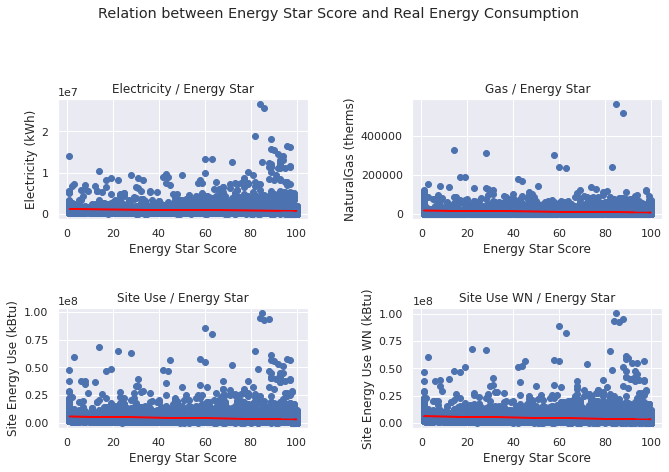

In [168]:
# ScatterPlots of main energy consumption variables and EnergyStar Score

fig, axs = plt.subplots(2, 2)

fig.set_figheight(7)
fig.set_figwidth(10)

fig.suptitle('Relation between Energy Star Score and Real Energy Consumption')

axs[0, 0].scatter(Data['ENERGYSTARScore'], Data['Electricity(kWh)'])
axs[0, 0].set_title('Electricity / Energy Star')

X = Data['ENERGYSTARScore'].iloc[0:100000]
y = Data['Electricity(kWh)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 0].plot(Data['ENERGYSTARScore'], Data['ENERGYSTARScore']*m+b, color='red')
axs[0, 0].set(xlabel='Energy Star Score', ylabel='Electricity (kWh)')

axs[0, 1].scatter(Data['ENERGYSTARScore'], Data['NaturalGas(therms)'])
axs[0, 1].set_title('Gas / Energy Star')

X = Data['ENERGYSTARScore'].iloc[0:100000]
y = Data['NaturalGas(therms)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 1].plot(Data['ENERGYSTARScore'], Data['ENERGYSTARScore']*m+b, color='red')
axs[0, 1].set(xlabel='Energy Star Score', ylabel='NaturalGas (therms)')

axs[1, 0].scatter(Data['ENERGYSTARScore'], Data['SiteEnergyUse(kBtu)'])
axs[1, 0].set_title('Site Use / Energy Star')

X = Data['ENERGYSTARScore'].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 0].plot(Data['ENERGYSTARScore'], Data['ENERGYSTARScore']*m+b, color='red')
axs[1, 0].set(xlabel='Energy Star Score', ylabel='Site Energy Use (kBtu)')


axs[1, 1].scatter(Data['ENERGYSTARScore'], Data['SiteEnergyUseWN(kBtu)'])
axs[1, 1].set_title('Site Use WN / Energy Star')

X = Data['ENERGYSTARScore'].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 1].plot(Data['ENERGYSTARScore'], Data['ENERGYSTARScore']*m+b, color='red')
axs[1, 1].set(xlabel='Energy Star Score', ylabel='Site Energy Use WN (kBtu)')


fig.tight_layout(pad=3.0)

Le Energy Star Score seul, est un très mauvais prédicteur de la consommation énergétique.

En regardant de plus près la description de l'Energy Star score cela n'est pas étonnant.
En effet le but de l'Energy Star score n'est pas d'aider à prédire la consommation énergétique.
Son but est d'indiquer aux propriétaires des batiments dans quel quantile de consommation énergétique ils se situent parmis les batiments qui présentent les mêmes charactéristiques.

Le but de cet Energy Star Score est donc d'inciter les propriétaires à amméliorer leur consommation énergétique, en les situant dans la distribution de consommation énergétique des batiments comparables, sur le quantile qui leur correspond.
Ainsi une maison de 100m2 pourrait avoir le même Energy Star Score qu'un gratte-ciel de 40 étages, car l'Energy Star Score situe leurs quantiles respectifs dans des distributions de batiments différents (parmis les maisons de 100m2 dans le premier cas, parmis les immeubles de 40 étages dans le second cas).


In [23]:
Surface45thQuantile = np.quantile(Data['PropertyGFATotal'], 0.45)
Surface55thQuantile = np.quantile(Data['PropertyGFATotal'], 0.55)

Condition = []

for i in range(len(Property_Type)):
    Condition0 = (Data[Property_Type[i]] == 1)
    if len(Data['PropertyGFATotal'][Condition0]) > 10:
        Surface45thQuantile = np.quantile(Data['PropertyGFATotal'][Condition0], 0.45)
        Surface55thQuantile = np.quantile(Data['PropertyGFATotal'][Condition0], 0.55)
        Condition.append((Data[Property_Type[i]] == 1) & (Data['PropertyGFATotal'] > Surface45thQuantile) & (Data['PropertyGFATotal'] < Surface55thQuantile))     
    else:
         Condition.append('nothing')

NewCondition = []
NewType = []
            
for i in range(len(Property_Type)):
    if len(Condition[i]) != 7:
        if len(Data['ENERGYSTARScore'][Condition[i]]) > 5:
            NewCondition.append(Condition[i])
            NewType.append(Property_Type[i])
    else:
        if Condition[i] != 'nothing':
            NewCondition.append(Condition[i])
            NewType.append(Property_Type[i])


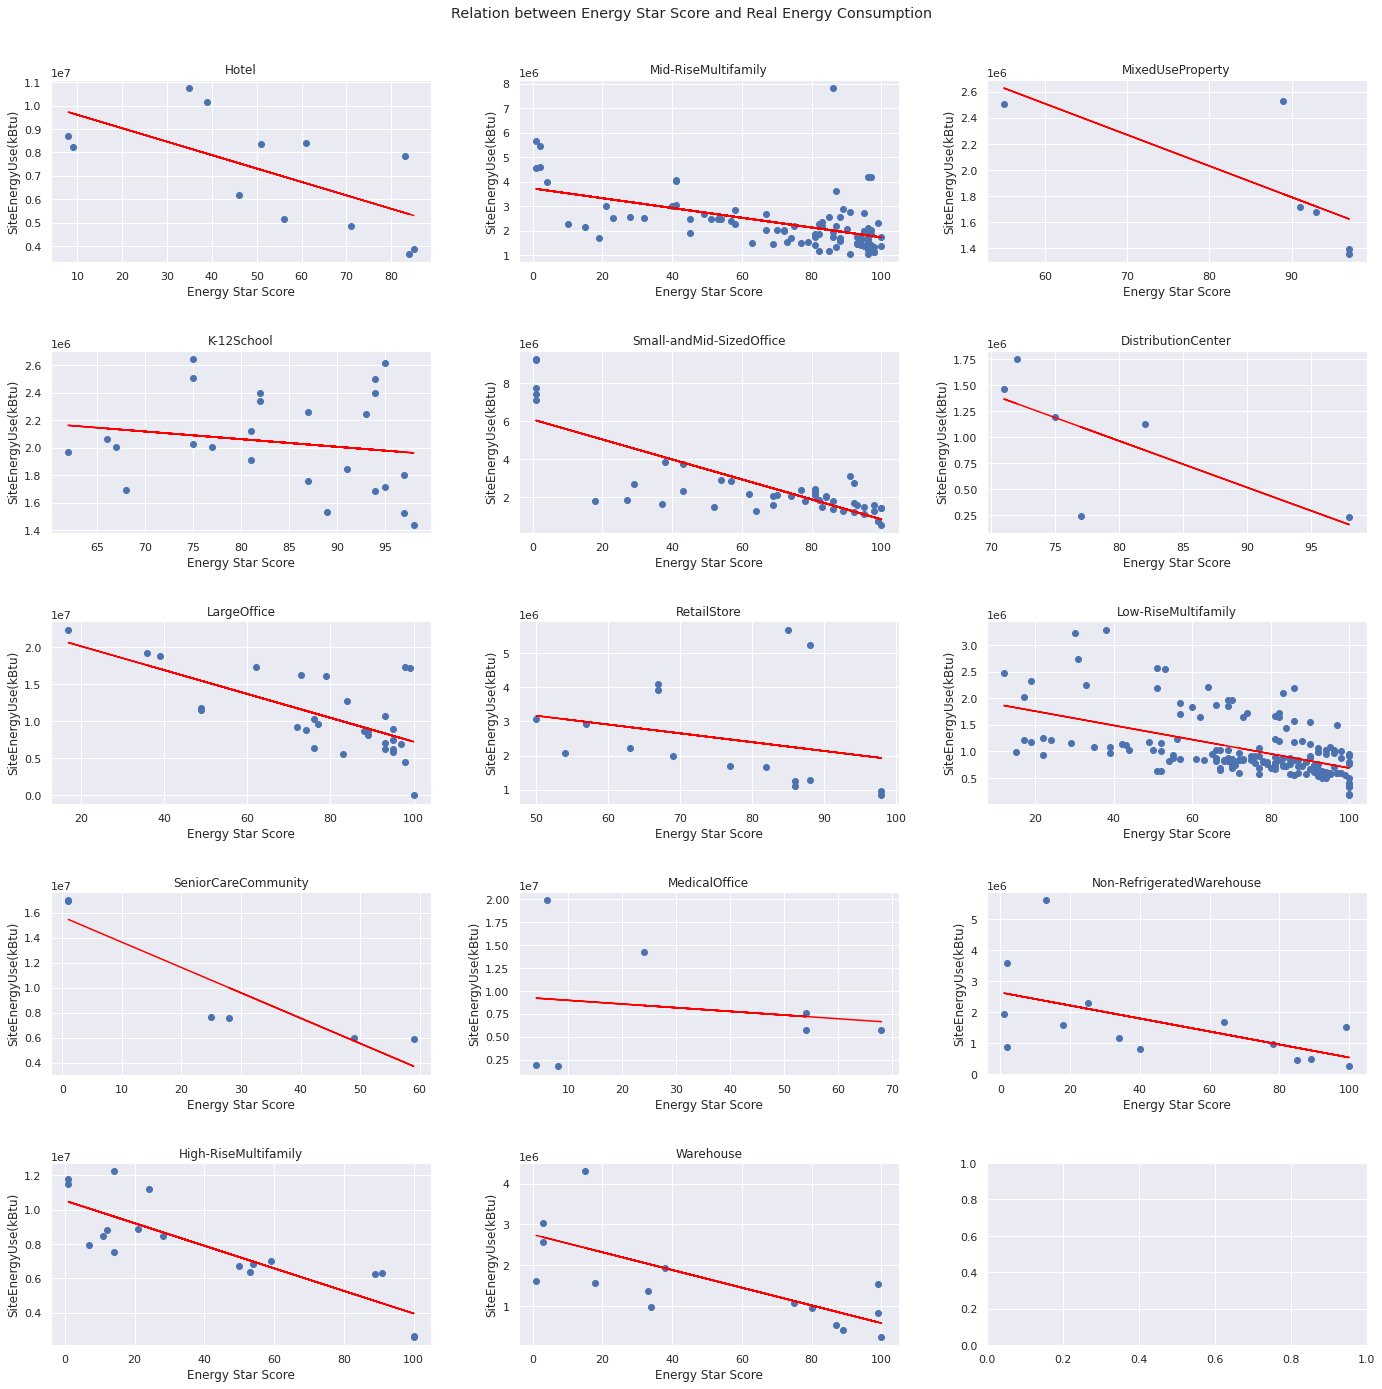

In [24]:
# ScatterPlots of main energy consumption variables and EnergyStar Score

fig, axs = plt.subplots(5, 3)

fig.set_figheight(20)
fig.set_figwidth(20)

fig.suptitle('Relation between Energy Star Score and Real Energy Consumption')

axs[0, 0].scatter(Data['ENERGYSTARScore'][NewCondition[0]], Data['SiteEnergyUse(kBtu)'][NewCondition[0]])
axs[0, 0].set_title(NewType[0])

X = Data['ENERGYSTARScore'][NewCondition[0]].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'][NewCondition[0]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 0].plot(Data['ENERGYSTARScore'][NewCondition[0]], Data['ENERGYSTARScore'][NewCondition[0]]*m+b, color='red')
axs[0, 0].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')



axs[0, 1].scatter(Data['ENERGYSTARScore'][NewCondition[1]], Data['SiteEnergyUse(kBtu)'][NewCondition[1]])
axs[0, 1].set_title(NewType[1])

X = Data['ENERGYSTARScore'][NewCondition[1]].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'][NewCondition[1]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 1].plot(Data['ENERGYSTARScore'][NewCondition[1]], Data['ENERGYSTARScore'][NewCondition[1]]*m+b, color='red')
axs[0, 1].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')


axs[0, 2].scatter(Data['ENERGYSTARScore'][NewCondition[2]], Data['SiteEnergyUse(kBtu)'][NewCondition[2]])
axs[0, 2].set_title(NewType[2])

X = Data['ENERGYSTARScore'][NewCondition[2]].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'][NewCondition[2]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[0, 2].plot(Data['ENERGYSTARScore'][NewCondition[2]], Data['ENERGYSTARScore'][NewCondition[2]]*m+b, color='red')
axs[0, 2].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')


axs[1, 0].scatter(Data['ENERGYSTARScore'][NewCondition[3]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[3]])
axs[1, 0].set_title(NewType[3])

X = Data['ENERGYSTARScore'][NewCondition[3]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[3]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 0].plot(Data['ENERGYSTARScore'][NewCondition[3]], Data['ENERGYSTARScore'][NewCondition[3]]*m+b, color='red')
axs[1, 0].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')



axs[1, 1].scatter(Data['ENERGYSTARScore'][NewCondition[4]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[4]])
axs[1, 1].set_title(NewType[4])

X = Data['ENERGYSTARScore'][NewCondition[4]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[4]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 1].plot(Data['ENERGYSTARScore'][NewCondition[4]], Data['ENERGYSTARScore'][NewCondition[4]]*m+b, color='red')
axs[1, 1].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')





axs[1, 2].scatter(Data['ENERGYSTARScore'][NewCondition[5]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[5]])
axs[1, 2].set_title(NewType[5])

X = Data['ENERGYSTARScore'][NewCondition[5]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[5]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[1, 2].plot(Data['ENERGYSTARScore'][NewCondition[5]], Data['ENERGYSTARScore'][NewCondition[5]]*m+b, color='red')
axs[1, 2].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')





axs[2, 0].scatter(Data['ENERGYSTARScore'][NewCondition[6]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[6]])
axs[2, 0].set_title(NewType[6])

X = Data['ENERGYSTARScore'][NewCondition[6]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[6]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[2, 0].plot(Data['ENERGYSTARScore'][NewCondition[6]], Data['ENERGYSTARScore'][NewCondition[6]]*m+b, color='red')
axs[2, 0].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')



axs[2, 1].scatter(Data['ENERGYSTARScore'][NewCondition[7]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[7]])
axs[2, 1].set_title(NewType[7])

X = Data['ENERGYSTARScore'][NewCondition[7]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[7]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[2, 1].plot(Data['ENERGYSTARScore'][NewCondition[7]], Data['ENERGYSTARScore'][NewCondition[7]]*m+b, color='red')
axs[2, 1].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')




axs[2, 2].scatter(Data['ENERGYSTARScore'][NewCondition[8]], Data['SiteEnergyUse(kBtu)'][NewCondition[8]])
axs[2, 2].set_title(NewType[8])

X = Data['ENERGYSTARScore'][NewCondition[8]].iloc[0:100000]
y = Data['SiteEnergyUse(kBtu)'][NewCondition[8]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[2, 2].plot(Data['ENERGYSTARScore'][NewCondition[8]], Data['ENERGYSTARScore'][NewCondition[8]]*m+b, color='red')
axs[2, 2].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')





axs[3, 0].scatter(Data['ENERGYSTARScore'][NewCondition[9]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[9]])
axs[3, 0].set_title(NewType[9])

X = Data['ENERGYSTARScore'][NewCondition[9]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[9]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[3, 0].plot(Data['ENERGYSTARScore'][NewCondition[9]], Data['ENERGYSTARScore'][NewCondition[9]]*m+b, color='red')
axs[3, 0].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')



axs[3, 1].scatter(Data['ENERGYSTARScore'][NewCondition[10]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[10]])
axs[3, 1].set_title(NewType[10])

X = Data['ENERGYSTARScore'][NewCondition[10]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[10]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[3, 1].plot(Data['ENERGYSTARScore'][NewCondition[10]], Data['ENERGYSTARScore'][NewCondition[10]]*m+b, color='red')
axs[3, 1].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')





axs[3, 2].scatter(Data['ENERGYSTARScore'][NewCondition[11]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[11]])
axs[3, 2].set_title(NewType[11])

X = Data['ENERGYSTARScore'][NewCondition[11]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[11]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[3, 2].plot(Data['ENERGYSTARScore'][NewCondition[11]], Data['ENERGYSTARScore'][NewCondition[11]]*m+b, color='red')
axs[3, 2].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')




axs[4, 0].scatter(Data['ENERGYSTARScore'][NewCondition[14]], Data['SiteEnergyUseWN(kBtu)'][NewCondition[14]])
axs[4, 0].set_title(NewType[14])

X = Data['ENERGYSTARScore'][NewCondition[14]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[14]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[4, 0].plot(Data['ENERGYSTARScore'][NewCondition[14]], Data['ENERGYSTARScore'][NewCondition[14]]*m+b, color='red')
axs[4, 0].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')




axs[4, 1].scatter(Data['ENERGYSTARScore'][NewCondition[15]], Data['SiteEnergyUse(kBtu)'][NewCondition[15]])
axs[4, 1].set_title(NewType[15])

X = Data['ENERGYSTARScore'][NewCondition[15]].iloc[0:100000]
y = Data['SiteEnergyUseWN(kBtu)'][NewCondition[15]].iloc[0:100000]

m, b = np.polyfit(X, y, 1)

axs[4, 1].plot(Data['ENERGYSTARScore'][NewCondition[15]], Data['ENERGYSTARScore'][NewCondition[15]]*m+b, color='red')
axs[4, 1].set(xlabel='Energy Star Score', ylabel='SiteEnergyUse(kBtu)')


fig.tight_layout(pad=3.0)

On voit assez distinctement la relation négative qui existe entre le Energy Star Score et la consommation réelle d'énergie pour chaque type de batiment et en controlant la surface de l'immeuble (percentiles 45 à 55 de surface).

#### 5.2. Inclure le Energy Star Score dans la prédiction de CO2

In [30]:

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Ones',  'ENERGYSTARScore'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


StartEnergy = time.perf_counter()

reg = LinearRegression().fit(X_train, y_train)

Predicted_y = reg.predict(X_train)
EnLinSiteEnergyTraining_R2 =  reg.score(X_train, y_train)
EnLinSiteEnergyTraining_R2 = round(EnLinSiteEnergyTraining_R2, 3)

AdEnLinSiteEnergyTraining_R2 = 1 - ((1-reg.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdEnLinSiteEnergyTraining_R2 = round(AdEnLinSiteEnergyTraining_R2, 3)

EnLinSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
EnLinSiteEnergyTraining_MSE = round(EnLinSiteEnergyTraining_MSE)

EnLinSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
EnLinSiteEnergyTraining_MAE = round(EnLinSiteEnergyTraining_MAE)

Predicted_y = reg.predict(X_test)
EnLinSiteEnergyTest_R2 = reg.score(X_test, y_test)
EnLinSiteEnergyTest_R2 = round(EnLinSiteEnergyTest_R2, 3)

AdEnLinSiteEnergyTest_R2 = 1 - ((1-reg.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdEnLinSiteEnergyTest_R2 = round(AdEnLinSiteEnergyTest_R2, 3)

EnLinSiteEnergyTest_MSE = mean_squared_error(Predicted_y , y_test)
EnLinSiteEnergyTest_MSE = round(EnLinSiteEnergyTest_MSE)

EnLinSiteEnergyTest_MAE = mean_absolute_error(Predicted_y , y_test)
EnLinSiteEnergyTest_MAE = round(EnLinSiteEnergyTest_MAE)
EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0
    
TimeEnergy = round(TimeEnergy, 0)
EnStarLinTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))




space = 27
space2 = 17

print('Linear Regression including Energy Star Score:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{EnLinSiteEnergyTraining_R2 : ^{space2}}{AdEnLinSiteEnergyTraining_R2 : ^{space2}}{EnLinSiteEnergyTraining_MSE : ^{space2}}{EnLinSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{EnLinSiteEnergyTest_R2 : ^{space2}}{AdEnLinSiteEnergyTest_R2 : ^{space2}}{EnLinSiteEnergyTest_MSE : ^{space2}}{EnLinSiteEnergyTest_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")

Linear Regression including Energy Star Score:
 
                                 R2 :           Adj_R2 :          MSE :            MAE :            Time :      
 
Site Energy Training :           0.889            0.887        5563153807345       1191838     
Site Energy Test :               0.869            0.865        5833684856705       1252979          0:00:00     


In [41]:

X = Data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Electricity(kWh)', 'Ones', 'ENERGYSTARScore'] + Property_Type_ElecOrder + Property_Type_GPA].iloc[0:10000000]
y = Data['SiteEnergyUse(kBtu)'].iloc[0:10000000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

StartEnergy = time.perf_counter()

model = rfr.fit(X_train, y_train)

Predicted_y = rfr.predict(X_train)
EnForSiteEnergyTraining_R2 =  rfr.score(X_train, y_train)
EnForSiteEnergyTraining_R2 = round(EnForSiteEnergyTraining_R2, 3)

AdEnForSiteEnergyTraining_R2 = 1 - ((1-rfr.score(X_train, y_train))*(len(y_train) - 1) / (len(y_train) - len(X_train.iloc[0,:])  - 1))
AdEnForSiteEnergyTraining_R2 = round(AdEnForSiteEnergyTraining_R2, 3)

EnForSiteEnergyTraining_MSE =  mean_squared_error(Predicted_y, y_train)
EnForSiteEnergyTraining_MSE = round(EnForSiteEnergyTraining_MSE)

EnForSiteEnergyTraining_MAE =  mean_absolute_error(Predicted_y, y_train)
EnForSiteEnergyTraining_MAE = round(EnForSiteEnergyTraining_MAE)

Predicted_y = rfr.predict(X_test)
EnForSiteEnergyTest_R2 =  rfr.score(X_test, y_test)
EnForSiteEnergyTest_R2 = round(EnForSiteEnergyTest_R2, 3)

AdEnForSiteEnergyTest_R2 = 1 - ((1-rfr.score(X_test, y_test))*(len(y_test) - 1) / (len(y_test) - len(X_test.iloc[0,:])  - 1))
AdEnForSiteEnergyTest_R2 = round(AdEnForSiteEnergyTest_R2, 3)

EnForSiteEnergyTest_MSE =  mean_squared_error(Predicted_y, y_test)
EnForSiteEnergyTest_MSE = round(EnForSiteEnergyTest_MSE)

EnForSiteEnergyTest_MAE =  mean_absolute_error(Predicted_y, y_test)
EnForSiteEnergyTest_MAE = round(EnForSiteEnergyTest_MAE)
EndEnergy = time.perf_counter()

TimeEnergy = EndEnergy - StartEnergy

if TimeEnergy < 0:
    TimeEnergy = 0

TimeEnergy = round(TimeEnergy, 0)
EnStarForTimeEnergy = str(datetime.timedelta(seconds=TimeEnergy))

print('Random Forest Including Energy Star Score :')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')

print(f"{'Site Energy Training : ' : <{space}}{EnForSiteEnergyTraining_R2 : ^{space2}}{AdEnForSiteEnergyTraining_R2 : ^{space2}}{EnForSiteEnergyTraining_MSE : ^{space2}}{EnForSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Site Energy Test : ' : <{space}}{EnForSiteEnergyTest_R2 : ^{space2}}{AdEnForSiteEnergyTest_R2 : ^{space2}}{EnForSiteEnergyTest_MSE : ^{space2}}{EnForSiteEnergyTest_MAE : ^{space2}}{EnStarForTimeEnergy  : ^{space2}}")

Random Forest Including Energy Star Score :
 
                                               R2 :              Adj_R2 :              MSE :               MAE :              Time :        
 
Site Energy Training :                         0.992               0.992            392474532589           239609       
Site Energy Test :                             0.925               0.923           3324540215284           671789             0:00:16       


In [42]:
space = 40
space2 = 20

print('Energy:')
print(' ')

print(f"{' ' : <{space}}{'R2 : ' : ^{space2}}{'Adj_R2 : ' : ^{space2}}{'MSE : ' : ^{space2}}{'MAE : ' : ^{space2}}{'Time : ' : ^{space2}}")
print(' ')


print(f"{'Linear Regression: ' : <{space}}")
print(' ')
      
print(f"{'Training : ' : <{space}}{LinSiteEnergyTraining_R2 : ^{space2}}{AdLinSiteEnergyTraining_R2 : ^{space2}}{LinSiteEnergyTraining_MSE : ^{space2}}{LinSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Training with Energy Star Score : ' : <{space}}{EnLinSiteEnergyTraining_R2 : ^{space2}}{AdEnLinSiteEnergyTraining_R2 : ^{space2}}{EnLinSiteEnergyTraining_MSE : ^{space2}}{EnLinSiteEnergyTraining_MAE : ^{space2}}")

print(' ')
      
print(f"{'Test : ' : <{space}}{LinSiteEnergyTest_R2 : ^{space2}}{AdLinSiteEnergyTest_R2 : ^{space2}}{LinSiteEnergyTest_MSE : ^{space2}}{LinSiteEnergyTest_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")
print(f"{'Test with Energy Star Score : ' : <{space}}{EnLinSiteEnergyTest_R2 : ^{space2}}{AdEnLinSiteEnergyTest_R2 : ^{space2}}{EnLinSiteEnergyTest_MSE : ^{space2}}{EnLinSiteEnergyTest_MAE : ^{space2}}{LinTimeEnergy : ^{space2}}")
print(' ')
print(' ')

print(f"{'Random Forest : ' : <{space}}")
print(' ')

print(f"{'Training : ' : <{space}}{ForSiteEnergyTraining_R2 : ^{space2}}{AdForSiteEnergyTraining_R2 : ^{space2}}{ForSiteEnergyTraining_MSE : ^{space2}}{ForSiteEnergyTraining_MAE : ^{space2}}")
print(f"{'Training with Energy Star Score : ' : <{space}}{EnForSiteEnergyTraining_R2 : ^{space2}}{AdEnForSiteEnergyTraining_R2 : ^{space2}}{EnForSiteEnergyTraining_MSE : ^{space2}}{EnForSiteEnergyTraining_MAE : ^{space2}}")


print(' ')

print(f"{'Test : ' : <{space}}{ForSiteEnergyTest_R2 : ^{space2}}{AdForSiteEnergyTest_R2 : ^{space2}}{ForSiteEnergyTest_MSE : ^{space2}}{ForSiteEnergyTest_MAE : ^{space2}}{ForTimeEnergy : ^{space2}}")
print(f"{'Test with Energy Star Score : ' : <{space}}{EnForSiteEnergyTest_R2 : ^{space2}}{AdEnForSiteEnergyTest_R2 : ^{space2}}{EnForSiteEnergyTest_MSE : ^{space2}}{EnForSiteEnergyTest_MAE : ^{space2}}{EnStarForTimeEnergy : ^{space2}}")
print(' ')
print(' ')
print(' ')




Energy:
 
                                               R2 :              Adj_R2 :              MSE :               MAE :              Time :        
 
Linear Regression:                      
 
Training :                                     0.874               0.871           6349188783594          1202060       
Training with Energy Star Score :              0.889               0.887           5563153807345          1191838       
 
Test :                                         0.846               0.842           6826114074273          1243040             0:00:00       
Test with Energy Star Score :                  0.869               0.865           5833684856705          1252979             0:00:00       
 
 
Random Forest :                         
 
Training :                                     0.993               0.992            305109543659           260440       
Training with Energy Star Score :              0.992               0.992            392474532589           239

On constate que le fait d'inclure le Energy Star Score dans la prédiction d'Emission CO2, permet très légèrement la prédiction d'émission de CO2.

En revanche, il semble qu'inclure le Energy Star Score dans la prédiction correspond à du Data Leakage, car il nécessite au préalable de mesurer les émissions de CO2 des immeubles.